# Определение возраста покупателей

### План работы

1. Проведем исследовательский анализ набора фотографий.
2. Подготовим данные к обучению.
3. Обучим нейронную сеть и оценим её качество.

In [1]:
from matplotlib import pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np

## 1. Исследовательский анализ данных

Импортируем файл .csv и изображения.

In [2]:
labels = pd.read_csv('F:/DS/Projects/CV/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='F:/DS/Projects/CV/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Выделим фичи и таргет.

In [3]:
features, target = next(train_gen_flow)

Посмотрим размер выборки.

In [4]:
features.shape

(32, 224, 224, 3)

Выборка состоит из 32 трехканальных изображений размером 224*224.\
Всего 7591 картинка, поделенная на батчи по 32.

Посмотрим на файл с таргетом.

In [5]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


Text(0.5, 1.0, 'Распределение возраста в выборке')

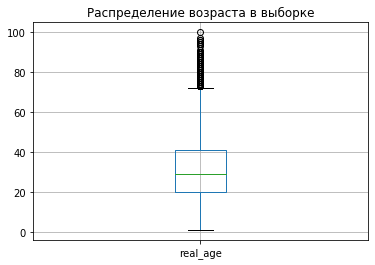

In [6]:
ax = labels.boxplot()
plt.title('Распределение возраста в выборке')

В выборке больше всего людей от 20 до 40 лет.

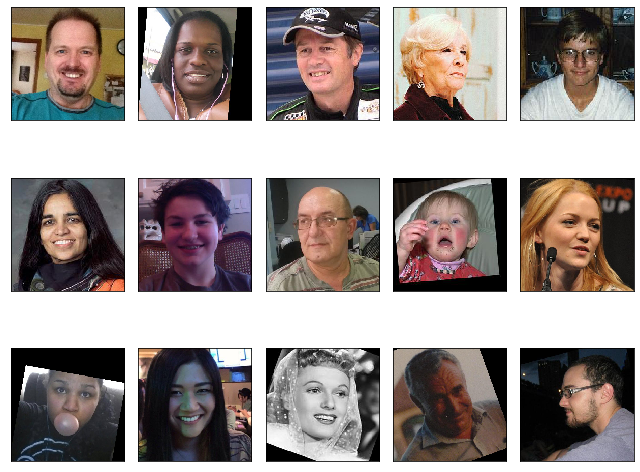

In [8]:
fig = plt.figure(figsize=(9,9))
for i in range(15):
    fig.add_subplot(3, 5, i+1)
    plt.imshow(features[i])
# для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Видим, что изображения понятные (лицо крупным планом), кроме того:
- люди сфотографированы под разным углом,
- имеют разный фон (иногда яркий),
- присуствуют как цветные, так и черно-белые фото.

## 2. Обучение модели

Перенесем сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

def load_train(path):

    datagen = ImageDataGenerator(validation_split=0.25,rescale =1/255, horizontal_flip = True)
    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path +'labels.csv'),
        directory = path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
        
    return train_datagen_flow

def load_test(path):

    datagen = ImageDataGenerator(validation_split=0.25,rescale =1/255)
    val_datagen_flow = datagen.flow_from_dataframe(
        dataframe = pd.read_csv(path +'labels.csv'),
        directory = path +'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
        
    return val_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(
        input_shape=input_shape,
        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
        include_top=False
        )

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0001)
    model.compile(
        optimizer=optimizer,
        loss='mse',
        metrics=['mae']
        )
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    train_datagen_flow = train_data
    val_datagen_flow = test_data
    
    model.fit(
        train_datagen_flow,
        validation_data = val_datagen_flow,
        batch_size=batch_size, epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2, shuffle=True)

    return model

```

```

Found 5694 validated image filenames.
Found 1897 validated image filenames.

<class 'tensorflow.python.keras.engine.sequential.Sequential'>

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 92s - loss: 247.6801 - mae: 11.2463 - val_loss: 638.9680 - val_mae: 20.2940
Epoch 2/10
178/178 - 37s - loss: 77.2265 - mae: 6.6432 - val_loss: 669.2960 - val_mae: 20.8654
Epoch 3/10
178/178 - 37s - loss: 50.0913 - mae: 5.3468 - val_loss: 220.6590 - val_mae: 11.2135
Epoch 4/10
178/178 - 38s - loss: 35.6729 - mae: 4.5553 - val_loss: 105.2719 - val_mae: 7.8110
Epoch 5/10
178/178 - 37s - loss: 27.2104 - mae: 3.9841 - val_loss: 91.0278 - val_mae: 7.2787
Epoch 6/10
178/178 - 37s - loss: 22.6023 - mae: 3.6095 - val_loss: 71.2783 - val_mae: 6.3481
Epoch 7/10
178/178 - 37s - loss: 18.1474 - mae: 3.2476 - val_loss: 66.9840 - val_mae: 6.0851
Epoch 8/10
178/178 - 38s - loss: 15.3714 - mae: 2.9945 - val_loss: 88.9462 - val_mae: 7.0492
Epoch 9/10
178/178 - 38s - loss: 12.5569 - mae: 2.7047 - val_loss: 65.9794 - val_mae: 6.0058
Epoch 10/10
178/178 - 37s - loss: 10.0381 - mae: 2.4288 - val_loss: 66.7298 - val_mae: 6.0602

```

## 3. Анализ обученной модели

Итак, мы решили задачу регрессии - предсказание возраста про фотографии.\
В последнем слое оставили 1 нейрон, так как на выходе должно быть 1 число.\
Использовать функцию потерь MAE.\
Предпочли ее MSE, так как в данных (возрастах) есть выбросы.\
Соответственно, при возведении в квадрат, эти выбросы могли исказить картину.\
С помощью нейронной сети с архитектурой ResNet50 из коробки Keras теперь можем можем определять возраст по фотографии\
**с точностью +-6 лет**.

Настройки предобработки и параметров модели:
- валидационная выборка 25%
- числа в матрицах изображений уменьшены на 255
- горизонтальное отражение в аугментации
- в последнем слое активация Relu
- оптимизация с помощью алгоритма Adam
- 10 эпох
- использовование всех данных (шаг по эпохе равен величине эпохи)
- влюченное перемешивание данных